In [1]:
%matplotlib inline

import collections
import itertools
import json

from brewer2mpl import qualitative
from matplotlib import pyplot, rcParams
import pandas

In [2]:
with open('data/info.json') as f:
    metadata = json.load(f)

metadata['patch']

'7.0.0.15590'

In [3]:
with open('data/cards.json') as f:
    data = json.load(f)
    
# This yields an iterator that returns one card at a time.
cards = itertools.chain.from_iterable(data.values())
series = [pandas.Series(card) for card in cards]
cards = pandas.concat(series, axis=1, join='outer').T.set_index('cardId')
cards.head()

,artist,attack,cardSet,classes,collectible,cost,durability,elite,faction,flavor,...,imgGold,locale,mechanics,multiClassGroup,name,playerClass,race,rarity,text,type
cardId,,,,,,,,,,,,,,,,,,,,,
NEW1_016,Daren Bader,1,Reward,NaN,True,2,NaN,NaN,NaN,Pirates and Parrots go together like Virmen an...,...,http://wow.zamimg.com/images/hearthstone/cards...,enUS,[{'name': 'Battlecry'}],NaN,Captain's Parrot,Neutral,Beast,Epic,<b>Battlecry:</b> Put a random Pirate from you...,Minion
EX1_062,Dan Scott,2,Reward,NaN,True,4,NaN,True,Neutral,"He's a legend among murlocs. ""Mrghllghghllghg...",...,http://wow.zamimg.com/images/hearthstone/cards...,enUS,[{'name': 'Charge'}],NaN,Old Murk-Eye,Neutral,Murloc,Legendary,<b>Charge</b>. Has +1 Attack for each other Mu...,Minion
XXX_055e,NaN,NaN,Debug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,enUS,NaN,NaN,1000 Stats Enchant,Neutral,NaN,NaN,NaN,Enchantment
XXX_094,NaN,1,Debug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,http://wow.zamimg.com/images/hearthstone/cards...,enUS,NaN,NaN,AI Buddy - Blank Slate,Neutral,NaN,NaN,"Spawn into play to clear the entire board, bot...",Minion
XXX_111e,NaN,NaN,Debug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,enUS,NaN,NaN,"All Charge, All Windfury, All The Time",Neutral,NaN,NaN,Your minions always have <b>Charge</b> and <b>...,Enchantment


## Mana Curve by Card Set

/Users/renzolucioni/.virtualenvs/hearthstone/lib/python3.5/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


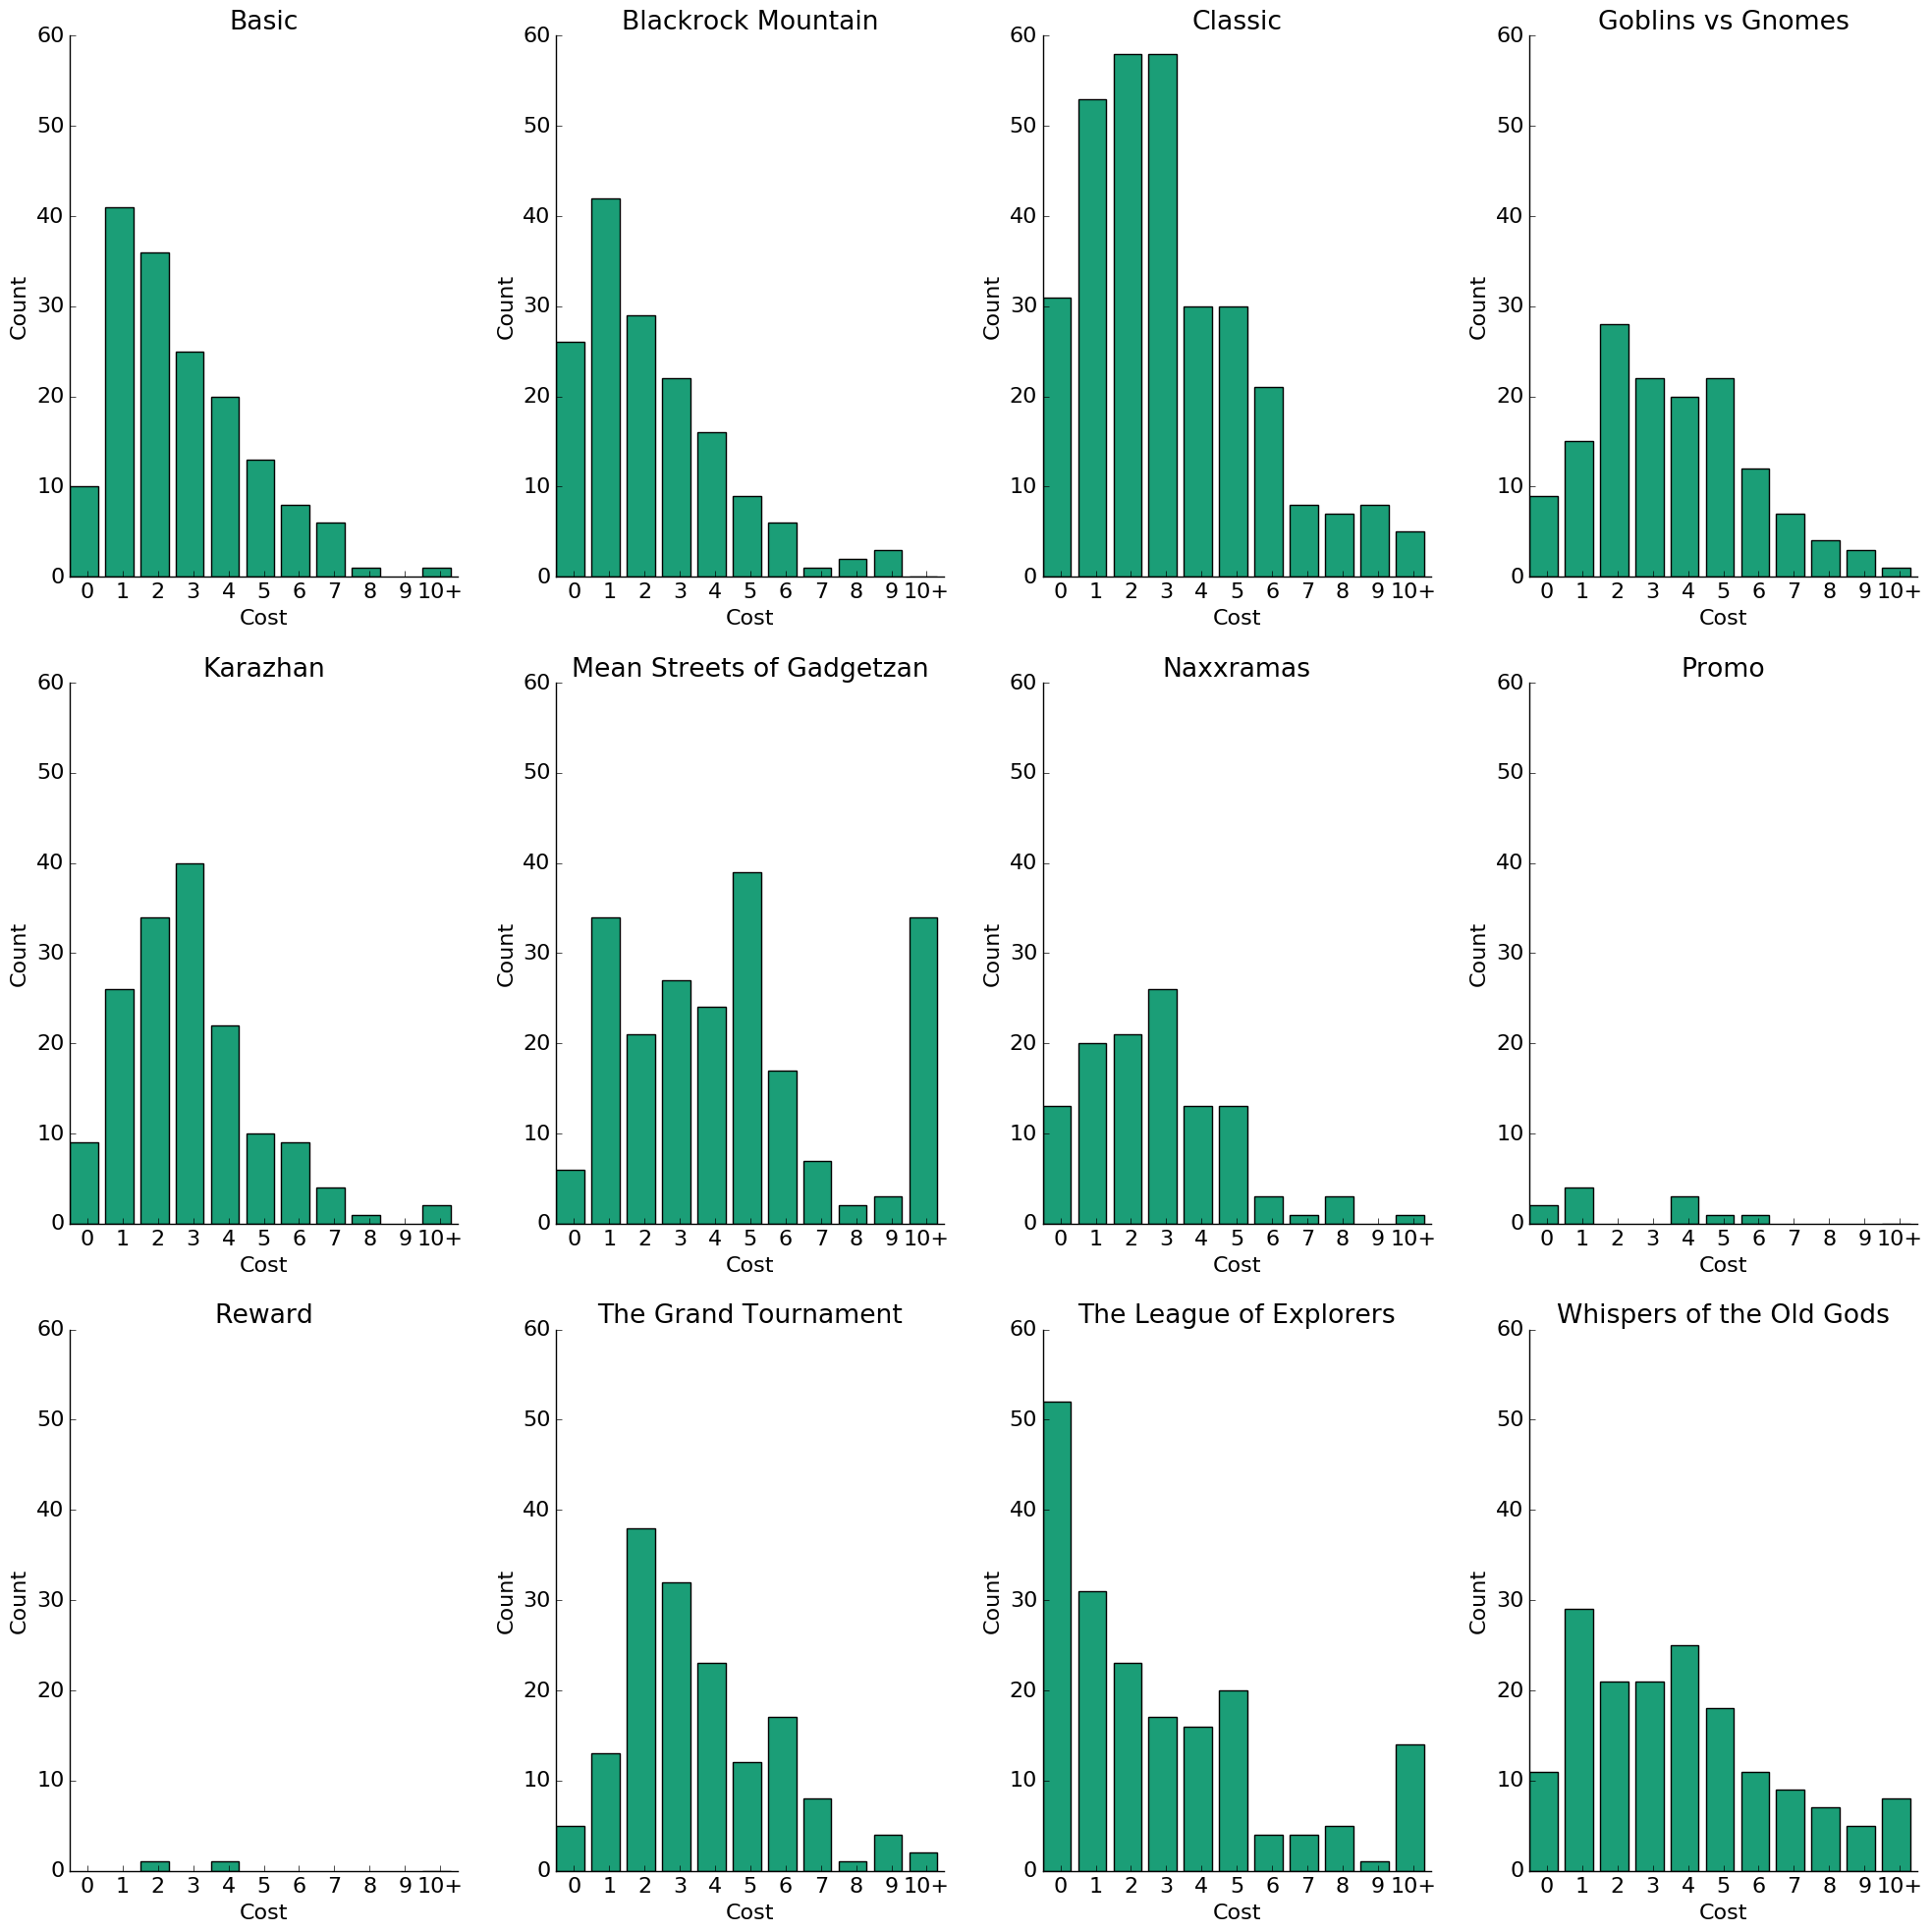

In [29]:
rcParams.update({
    'figure.figsize': (20, 20),
    'figure.dpi': 300,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'font.size': 16,
    'patch.edgecolor': 'black',
})


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks.
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn.
    """
    axes = axes or pyplot.gca()
    borders = {
        'bottom': axes.xaxis.tick_bottom,
        'left': axes.yaxis.tick_left,
        'right': axes.yaxis.tick_right,
        'top': axes.xaxis.tick_top,
    }

    # Turn off all ticks.
    axes.yaxis.set_ticks_position('none')
    axes.xaxis.set_ticks_position('none')

    for border, ticks in borders.items():
        is_visible = vars()[border]
        axes.spines[border].set_visible(is_visible)
        
        if is_visible:
            # Make requested ticks visible.
            ticks()

colors = qualitative.Dark2[7].mpl_colors

rows = 3
columns = 4
plot = 1

for card_set, group in cards.groupby('cardSet'):
    if card_set in metadata['wild']:
        axes = pyplot.subplot(rows, columns, plot)

        group = group.dropna(subset=['cost'])
        count = len(group)
        group['count'] = [1]*count
        group = group.groupby('cost').agg({'count': sum}).reset_index()
        
        big_drops = group[group['cost'] >= 10]
        all_drops = group[group['cost'] < 10].set_index('cost')
        all_drops = all_drops.append(pandas.Series({'count': sum(big_drops['count'])}, name=10))

        axes.bar(all_drops.index, all_drops['count'], color=colors[0])

        axes.set_title(card_set)
        
        axes.set_xlabel('Cost')
        axes.set_ylabel('Count')
        
        axes.set_xlim(0,11)
        axes.set_ylim(0, 60)
        
        axes.set_xticks([x + 0.5 for x in range(11)])
        axes.set_xticklabels([str(x) if x < 10 else '10+' for x in range(11)])
        
        remove_border()
        plot += 1

pyplot.tight_layout()